## Load Data

In [1]:
# Load pickled data
import pickle
import glob
import cv2

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

print("Updated Image Shape {}".format(X_train[0].shape))




Updated Image Shape (32, 32, 3)


## Visualize Data

11
Number of training samples = 27839
Number of testing samples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


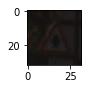

In [21]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

n_train = len(X_train)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])

print("Number of training samples =", n_train)
print("Number of testing samples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

## Preprocess Data

In [4]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

## Setup TensorFlow

In [5]:
import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 128

### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.

In [6]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    #Convolutional. Input = 32x32x1
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    #Activation.
    conv1 = tf.nn.relu(conv1)

    #Pooling
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Convolutional
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    #Activation
    conv2 = tf.nn.relu(conv2)

    #Pooling
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Flatten
    fc0   = flatten(conv2)
    
    #Fully Connected
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    #Activation
    fc1    = tf.nn.relu(fc1)

    #Fully Connected
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    #Activation
    fc2    = tf.nn.relu(fc2)

    #Fully Connected
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

## Features and Labels

In [7]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

## Training Pipeline

In [8]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation

In [9]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model

In [14]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.733

EPOCH 2 ...
Validation Accuracy = 0.875

EPOCH 3 ...
Validation Accuracy = 0.905

EPOCH 4 ...
Validation Accuracy = 0.926

EPOCH 5 ...
Validation Accuracy = 0.945

EPOCH 6 ...
Validation Accuracy = 0.941

EPOCH 7 ...
Validation Accuracy = 0.945

EPOCH 8 ...
Validation Accuracy = 0.960

EPOCH 9 ...
Validation Accuracy = 0.950

EPOCH 10 ...
Validation Accuracy = 0.958

Model saved


## Evaluate the Model

In [15]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.869


## Add New Images

In [16]:
images = []
signs = glob.glob('Images/*.png')

for sign in signs:
    sign.replace("\\", "/")
    print(sign)
    image = cv2.imread(sign)
    image = cv2.resize(image, (32, 32))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    images.append(image)
    cv2.imshow('image', image)
    cv2.waitKey(0)

Images\Sign1.png
Images\Sign2.png
Images\Sign3.png
Images\Sign4.png
Images\Sign5.png


## Evaluate

In [17]:
my_labels = [33, 21, 5, 14, 17]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    my_accuracy = evaluate(images, my_labels)
    print(my_accuracy)
    print("Test Set Accuracy = {:.3f}".format(my_accuracy))

0.800000011921
Test Set Accuracy = 0.800


## This shows the top five softmax probabilities of the predictions on the captured images

good


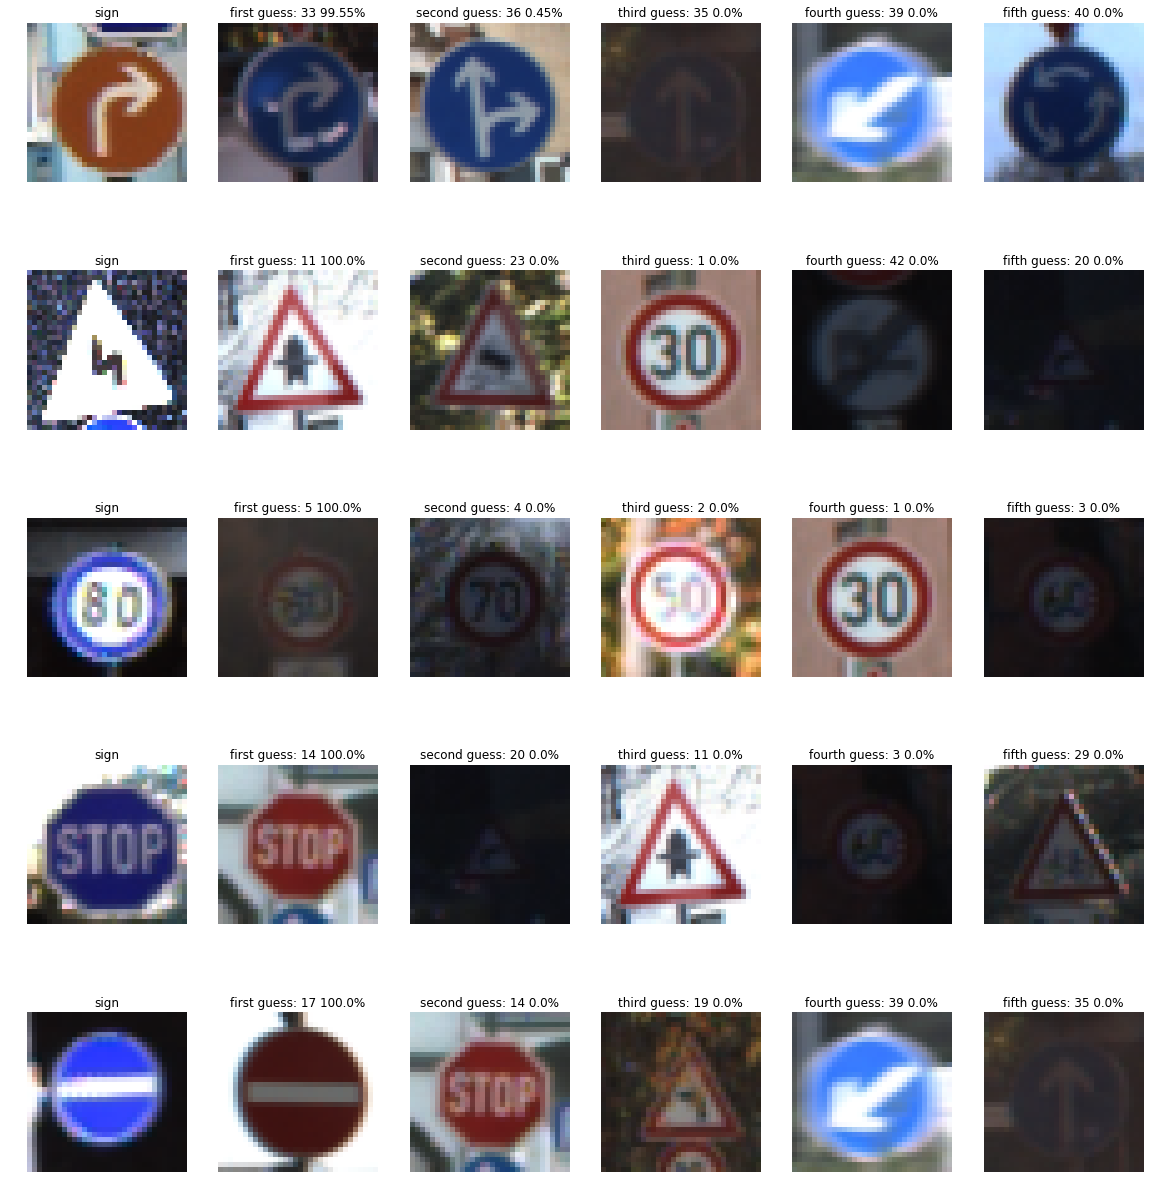

In [18]:
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=5)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: images})
    my_top_k = sess.run(top_k, feed_dict={x: images})
    print("good")
    
    #create figures
    fig, subs = plt.subplots(len(images),6, figsize=(20, 22))
    subs = subs.ravel()
    
    for i, image in enumerate(images):
        
        #set input image
        subs[6*i].axis('off')
        subs[6*i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        subs[6*i].set_title('sign')
        
        #first guess
        guess1 = my_top_k[1][i][0]
        index1 = np.argwhere(y_validation == guess1)[0]
        subs[6*i+1].axis('off')
        subs[6*i+1].imshow(X_validation[index1].squeeze(), cmap='gray')
        subs[6*i+1].set_title("first guess: " + str(guess1) + " " + str(round(100*my_top_k[0][i][0], 2)) + "%")
        
        #second guess
        guess2 = my_top_k[1][i][1]
        index2 = np.argwhere(y_validation == guess2)[0]
        subs[6*i+2].axis('off')
        subs[6*i+2].imshow(X_validation[index2].squeeze(), cmap='gray')
        subs[6*i+2].set_title("second guess: " + str(guess2) + " " + str(round(100*my_top_k[0][i][1], 2)) + "%")
        
        #third guess
        guess3 = my_top_k[1][i][2]
        index3 = np.argwhere(y_validation == guess3)[0]
        subs[6*i+3].axis('off')
        subs[6*i+3].imshow(X_validation[index3].squeeze(), cmap='gray')
        subs[6*i+3].set_title("third guess: " + str(guess3) + " " + str(round(100*my_top_k[0][i][2], 2)) + "%")
        
        #fourth guess
        guess4 = my_top_k[1][i][3]
        index4 = np.argwhere(y_validation == guess4)[0]
        subs[6*i+4].axis('off')
        subs[6*i+4].imshow(X_validation[index4].squeeze(), cmap='gray')
        subs[6*i+4].set_title("fourth guess: " + str(guess4) + " " + str(round(100*my_top_k[0][i][3], 2)) + "%")
        
        #fifth guess
        guess5 = my_top_k[1][i][4]
        index5 = np.argwhere(y_validation == guess5)[0]
        subs[6*i+5].axis('off')
        subs[6*i+5].imshow(X_validation[index5].squeeze(), cmap='gray')
        subs[6*i+5].set_title("fifth guess: " + str(guess5) + " " + str(round(100*my_top_k[0][i][4], 2)) + "%")
    